In [ ]:
#importing libraries
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
!unzip '/content/gdrive/MyDrive/2.zip'
# extracts the files on colab virtual machine



Streaming output truncated to the last 5000 lines.
 extracting: 1/train/bird/passerine_s_001884.png  
 extracting: 1/train/bird/bird_s_000573.png  
 extracting: 1/train/bird/bird_s_002398.png  
  inflating: 1/train/bird/struthio_camelus_s_000971.png  
 extracting: 1/train/bird/rhea_americana_s_000613.png  
 extracting: 1/train/bird/bird_s_001708.png  
 extracting: 1/train/bird/emu_s_000219.png  
 extracting: 1/train/bird/pipit_s_000192.png  
 extracting: 1/train/bird/flightless_bird_s_000562.png  
 extracting: 1/train/bird/passerine_s_001221.png  
 extracting: 1/train/bird/struthio_camelus_s_000008.png  
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])



test_data_dir = "/content/1/test"
# take the dataset from the location nad transform it 

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)


        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=512, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=512)
        self.fc4 = nn.Linear(in_features=512, out_features=1024)
        self.fc5 = nn.Linear(in_features=1024, out_features=5)

         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x=self.fc5(x)
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()
net.load_state_dict(torch.load("/content/gdrive/MyDrive/new model.pth"))

# net = torch.load("/content/gdrive/MyDrive/bestmodel.pth",map_location ='cpu')

<All keys matched successfully>

In [ ]:
def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)
test(testloader,net)

100%|██████████| 625/625 [00:03<00:00, 198.63it/s]

Accuracy of the network on the test images: 81.560000 %


81.56

In [ ]:
mc_index=[]

target_labels=[]
predicted_labels=[]
def miss_classified_indexes_(net,testloader):
   total=4*len(testloader)
   incorrect=0
   
   with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            # print(images.shape)
            #   # torch.size[(3,64,64)] 
            # print(labels.shape)
            # # torch.size[(4)]
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            # print(outputs.shape)
            # torch.size[(4,5)]
            prob, predicted = torch.max(outputs.data, 1)
            # it finds  max probabilty of class() and the predicted class 
            # print("predicted",predicted)
            # print("labels",labels) 
            # print(predicted.shape)
            # torch.size[(4)]
            for i in range (4):
              target_labels.append(labels[i])
              predicted_labels.append(predicted[i])
              if (labels[i]!=predicted[i]):
                incorrect+=1
                # miss_classified_index.append(i)
           
   
   accuracy=1-(incorrect/total)
   print("accuracy",accuracy)
   
   return target_labels,predicted_labels

In [ ]:
target_labels,predicted_labels=miss_classified_indexes_(net,testloader)

100%|██████████| 625/625 [01:06<00:00,  9.42it/s]

accuracy 0.8148


In [ ]:
mc_index=[]
print(len(target_labels))
print(len(predicted_labels))
for i in range(2500):
  if (predicted_labels[i]!=target_labels[i]):
    mc_index.append(i)


2500
2500


In [ ]:
print(len(mc_index))

463


In [ ]:
mc_index

[0,
 4,
 8,
 37,
 38,
 80,
 92,
 95,
 109,
 111,
 114,
 134,
 147,
 164,
 170,
 180,
 184,
 186,
 187,
 199,
 211,
 212,
 218,
 229,
 232,
 237,
 241,
 255,
 266,
 270,
 271,
 300,
 303,
 311,
 332,
 345,
 358,
 363,
 365,
 368,
 372,
 375,
 380,
 381,
 396,
 416,
 423,
 424,
 428,
 435,
 440,
 442,
 492,
 502,
 508,
 528,
 529,
 532,
 544,
 546,
 547,
 548,
 551,
 553,
 556,
 568,
 570,
 571,
 574,
 582,
 583,
 631,
 644,
 651,
 664,
 669,
 675,
 676,
 679,
 681,
 685,
 694,
 696,
 699,
 719,
 758,
 764,
 767,
 771,
 772,
 780,
 798,
 806,
 812,
 827,
 839,
 841,
 851,
 857,
 871,
 888,
 895,
 899,
 920,
 923,
 924,
 927,
 933,
 935,
 962,
 1000,
 1004,
 1005,
 1006,
 1007,
 1008,
 1010,
 1024,
 1027,
 1028,
 1029,
 1031,
 1035,
 1038,
 1039,
 1043,
 1044,
 1045,
 1047,
 1050,
 1051,
 1055,
 1059,
 1062,
 1064,
 1065,
 1066,
 1074,
 1076,
 1078,
 1081,
 1082,
 1083,
 1086,
 1088,
 1091,
 1095,
 1098,
 1101,
 1111,
 1117,
 1118,
 1119,
 1122,
 1123,
 1124,
 1125,
 1126,
 1130,
 1134,
 

In [ ]:
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, _ = find_classes(test_data_dir)

True Class--cat
 Predicted Class-- bird


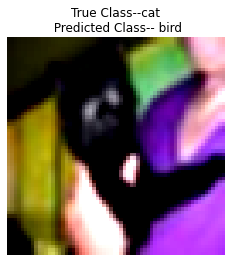

In [ ]:
def display(image,i):
  # image is atensor so have to convert to numpy
  img=image.numpy()
  # image standard scalar
  img=img-np.min(img)/abs(np.max(img)-np.min(img))
  title = 'True Class--'+classes[target_labels[i]] + '\n Predicted Class-- '+ classes[predicted_labels[i]]
    
  # print("true class",classes[target_labels[i]])
  # print("predicted class",classes[predicted_labels[i]])
  # reshape image from (3,64,64) to (64,64,3)  
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis("off")
  
  plt.title(title)
# for i in index:
import matplotlib.pyplot as plt

def images(i):
    #considers one image 
    image, label = testloader.dataset[i]
    outputs = net(image[None,:,:,:])
    _, predicted = torch.max(outputs, 1)
    print('True Class--'+classes[label] + '\n Predicted Class-- '+ classes[predicted])
    
    display(image,i)
images(1307)
   
   
#plt.savefig('../images/misclassified_imgs.png')

